In [1]:
# Cell 1 - imports & basic settings
!pip install torch torchvision timm scikit-image --quiet

import os, math, time, glob, random, csv
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.cuda.amp import autocast, GradScaler

from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [2]:
# Cell 2 - Dataset (true LR downsample from HR)
from google.colab import drive
drive.mount('/content/drive')
class SRDataset(Dataset):
    def __init__(self, folder, hr_size=192, scale=4, augment=False):
        exts = ("*.png","*.jpg","*.jpeg","*.tif","*.tiff")
        files=[]
        for e in exts:
            files += glob.glob(os.path.join(folder, e))
        files = sorted(files)
        if len(files)==0:
            raise ValueError(f"No images in {folder}")
        self.files = files
        self.hr_size = hr_size
        self.scale = scale
        self.lr_size = hr_size // scale
        self.augment = augment
        self.to_tensor = transforms.ToTensor()

    def __len__(self): return len(self.files)

    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert("RGB")
        w,h = img.size
        if w < self.hr_size or h < self.hr_size:
            img = img.resize((max(self.hr_size,w), max(self.hr_size,h)), Image.BICUBIC)
            w,h = img.size
        x = random.randint(0, w - self.hr_size)
        y = random.randint(0, h - self.hr_size)
        hr = img.crop((x,y,x+self.hr_size, y+self.hr_size))
        if self.augment and random.random() < 0.5: hr = hr.transpose(Image.FLIP_LEFT_RIGHT)
        # make LR by downscaling HR (true LR)
        lr = hr.resize((self.lr_size, self.lr_size), Image.BICUBIC)
        # optionally upsample LR to HR size for models that expect HR-shaped input (some EDSR implementations do internal upsampling)
        # here we pass LR (small) and model must upsample. If your EDSR expects LR input, return LR tensor only.
        return self.to_tensor(lr), self.to_tensor(hr)

# --- USER: set paths ---
train_dir = "/content/drive/MyDrive/Moon Kaggle Images/Training"   # change as needed
val_dir   = "/content/drive/MyDrive/Moon Kaggle Images/Testing"
hr_size = 192
scale = 4
batch_size = 8
num_workers = 2

train_ds = SRDataset(train_dir, hr_size=hr_size, scale=scale, augment=True)
val_ds   = SRDataset(val_dir,   hr_size=hr_size, scale=scale, augment=False)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=1, shuffle=False, num_workers=1, pin_memory=True)

print("Train / Val sizes:", len(train_ds), len(val_ds))
print("HR size:", hr_size, "LR size:", hr_size//scale, "scale:", scale)


Mounted at /content/drive
Train / Val sizes: 69 4
HR size: 192 LR size: 48 scale: 4


In [3]:
# Cell 3 - EDSR model (light, change n_feats/n_blocks if GPU allows)
class ResBlock(nn.Module):
    def __init__(self, n_feats, kernel_size=3):
        super().__init__()
        self.conv1 = nn.Conv2d(n_feats, n_feats, kernel_size, padding=kernel_size//2)
        self.relu  = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(n_feats, n_feats, kernel_size, padding=kernel_size//2)
    def forward(self,x):
        res = self.conv2(self.relu(self.conv1(x)))
        return x + res

class EDSR(nn.Module):
    def __init__(self, scale=4, n_feats=64, n_blocks=16):
        super().__init__()
        self.scale = scale
        self.head = nn.Conv2d(3, n_feats, 3, padding=1)
        body = [ResBlock(n_feats) for _ in range(n_blocks)]
        self.body = nn.Sequential(*body)
        self.body_conv = nn.Conv2d(n_feats, n_feats, 3, padding=1)
        # simple pixelshuffle upsampler
        up_layers = []
        m = int(math.log(scale,2))
        for _ in range(m):
            up_layers += [nn.Conv2d(n_feats, n_feats*4, 3, padding=1), nn.PixelShuffle(2), nn.ReLU(inplace=True)]
        self.upsample = nn.Sequential(*up_layers)
        self.tail = nn.Conv2d(n_feats, 3, 3, padding=1)

    def forward(self, lr):   # lr: [B,3,H_lr,W_lr]
        x = self.head(lr)
        res = self.body(x)
        res = self.body_conv(res) + x
        up = self.upsample(res)
        out = self.tail(up)
        return out.clamp(0.0, 1.0)   # output in [0,1]

# create model
n_feats = 64   # increase to 96/128 if GPU memory allows
n_blocks = 16  # increase to 32 if GPU allows
model = EDSR(scale=scale, n_feats=n_feats, n_blocks=n_blocks).to(device)
print("Model params:", sum(p.numel() for p in model.parameters())//1_000_00, "x10^5")


Model params: 15 x10^5


In [4]:
# Cell 4 - losses & VGG perceptual
l1_loss = nn.L1Loss().to(device)
# load VGG for perceptual (features)
import torchvision.models as tvm
vgg = tvm.vgg16(pretrained=True).features[:16].to(device).eval()
for p in vgg.parameters(): p.requires_grad = False

mean_vgg = torch.tensor([0.485,0.456,0.406], device=device).view(1,3,1,1)
std_vgg  = torch.tensor([0.229,0.224,0.225], device=device).view(1,3,1,1)

def perceptual_loss(sr, hr):
    # sr/hr expected in [0,1]
    sr_n = (sr - mean_vgg) / std_vgg
    hr_n = (hr - mean_vgg) / std_vgg
    f_sr = vgg(sr_n)
    f_hr = vgg(hr_n)
    return nn.functional.l1_loss(f_sr, f_hr)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:02<00:00, 228MB/s]


In [5]:
# Cell 5 - optim, scheduler (OneCycle), EMA, scaler
epochs = 100   # change if you want to train longer
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-6)
steps_per_epoch = max(1, len(train_loader))
from torch.optim.lr_scheduler import OneCycleLR
scheduler = OneCycleLR(optimizer, max_lr=1e-3, total_steps=epochs*steps_per_epoch, pct_start=0.1, div_factor=10, final_div_factor=1e4)

class EMA:
    def __init__(self, model, decay=0.9999):
        self.decay = decay
        self.shadow = {k:v.detach().cpu().clone() for k,v in model.state_dict().items()}
    def update(self, model):
        for k,v in model.state_dict().items():
            self.shadow[k] = self.decay * self.shadow[k] + (1.0-self.decay) * v.detach().cpu()
    def apply_to(self, model):
        model.load_state_dict({k:self.shadow[k].to(next(model.parameters()).device) for k in self.shadow})

ema = EMA(model, decay=0.9999)
scaler = GradScaler()


/tmp/ipython-input-2346057533.py:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [6]:
# Cell 6 - training loop (paste & run)
ckpt_dir = "/content/edsr_checkpoints"
os.makedirs(ckpt_dir, exist_ok=True)
best_psnr = -1.0

# loss weights
w_l1 = 1.0
w_perc = 0.01
w_ssim = 0.1   # if you want to add ssim loss term (1-ssim); optional

from skimage.metrics import structural_similarity as _ssim
def ssim_numpy(a,b):
    try:
        return _ssim(a, b, data_range=1.0, channel_axis=2)
    except TypeError:
        return _ssim(a, b, data_range=1.0, multichannel=True)

for epoch in range(1, epochs+1):
    model.train()
    running_loss = 0.0
    steps = 0
    t0 = time.time()
    for i, (lr, hr) in enumerate(train_loader):
        lr = lr.to(device)   # lr shape [B,3,H_lr,W_lr]
        hr = hr.to(device)   # hr shape [B,3,H_hr,W_hr]
        optimizer.zero_grad()
        with autocast():
            sr = model(lr)   # sr in [0,1]
            loss_l1 = l1_loss(sr, hr)
            loss_perc = perceptual_loss(sr, hr)
            # ssim term in [0,1]
            sr_np = sr.detach().cpu().permute(0,2,3,1).numpy()
            hr_np = hr.detach().cpu().permute(0,2,3,1).numpy()
            # compute ssim per batch item (slow but optional)
            ssim_batch = 0.0
            for k_ in range(sr_np.shape[0]):
                try:
                    ssim_batch += ssim_numpy(hr_np[k_], sr_np[k_])
                except:
                    ssim_batch += 0.0
            ssim_batch = ssim_batch / max(1, sr_np.shape[0])
            loss_ssim = 1.0 - ssim_batch
            loss = w_l1 * loss_l1 + w_perc * loss_perc + w_ssim * loss_ssim
        scaler.scale(loss).backward()
        # unscale -> clip -> step -> update (correct AMP order)
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        ema.update(model)
        running_loss += loss.item()
        steps += 1

    # validation per epoch
    model.eval()
    psnrs=[]; ssims=[]
    with torch.no_grad():
        for vlr, vhr in val_loader:
            vlr = vlr.to(device); vhr = vhr.to(device)
            out = model(vlr)
            out_np = out.detach().cpu().permute(0,2,3,1).numpy()
            hr_np  = vhr.detach().cpu().permute(0,2,3,1).numpy()
            out_np = np.clip(out_np, 0.0, 1.0)
            hr_np  = np.clip(hr_np, 0.0, 1.0)
            for b in range(out_np.shape[0]):
                p = compare_psnr(hr_np[b], out_np[b], data_range=1.0)
                try:
                    s = compare_ssim(hr_np[b], out_np[b], data_range=1.0, channel_axis=2)
                except:
                    s = compare_ssim(hr_np[b], out_np[b], data_range=1.0, multichannel=True)
                psnrs.append(p); ssims.append(s)
    mean_psnr = float(np.mean(psnrs)) if len(psnrs) else float('nan')
    mean_ssim = float(np.mean(ssims)) if len(ssims) else float('nan')

    if not math.isnan(mean_psnr) and mean_psnr > best_psnr:
        best_psnr = mean_psnr
        # save EMA-weighted model for best result
        tmp = os.path.join(ckpt_dir, "ema_best.pth")
        ema.apply_to(model)                  # apply ema to model copy
        torch.save(model.state_dict(), tmp)
        # reload original weights for continuing training (we'll re-instantiate later for eval)
        # better approach: keep a copy of ema.shadow separately; here we re-load from checkpoint below

    print(f"Epoch {epoch}/{epochs} | TrainLoss: {running_loss/max(1,steps):.6f} | Val PSNR: {mean_psnr:.3f} dB | Val SSIM: {mean_ssim:.4f} | Best PSNR: {best_psnr:.3f} | time: {time.time()-t0:.1f}s")


/tmp/ipython-input-1194088024.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/100 | TrainLoss: 0.309629 | Val PSNR: 15.494 dB | Val SSIM: 0.1046 | Best PSNR: 15.494 | time: 29.5s
Epoch 2/100 | TrainLoss: 0.341194 | Val PSNR: 13.868 dB | Val SSIM: 0.1361 | Best PSNR: 15.494 | time: 1.6s
Epoch 3/100 | TrainLoss: 0.240488 | Val PSNR: 17.354 dB | Val SSIM: 0.3113 | Best PSNR: 17.354 | time: 1.5s
Epoch 4/100 | TrainLoss: 0.315680 | Val PSNR: 17.949 dB | Val SSIM: 0.1552 | Best PSNR: 17.949 | time: 1.6s
Epoch 5/100 | TrainLoss: 0.305214 | Val PSNR: 18.766 dB | Val SSIM: 0.2749 | Best PSNR: 18.766 | time: 1.5s
Epoch 6/100 | TrainLoss: 0.286405 | Val PSNR: 16.691 dB | Val SSIM: 0.2341 | Best PSNR: 18.766 | time: 1.5s
Epoch 7/100 | TrainLoss: 0.157395 | Val PSNR: 22.135 dB | Val SSIM: 0.5133 | Best PSNR: 22.135 | time: 1.6s
Epoch 8/100 | TrainLoss: 0.270899 | Val PSNR: 19.874 dB | Val SSIM: 0.3068 | Best PSNR: 22.135 | time: 1.5s
Epoch 9/100 | TrainLoss: 0.125334 | Val PSNR: 25.324 dB | Val SSIM: 0.6728 | Best PSNR: 25.324 | time: 1.6s
Epoch 10/100 | TrainLoss: 0

Using Chandrayaan-3 required radius (px): 2  (meters_per_pixel = 0.45 )

--- sr_0_download (1).png full-res shape=1812x904 dtype= uint8 min/max/mean/std: 0 36 3.250101340131669 3.7705145756891163
sr_0_download (1).png | thresh=otsu | hazards=32 | hazard%=11.134% | best_r_proc=161px | req_proc=1px | SAFE=True


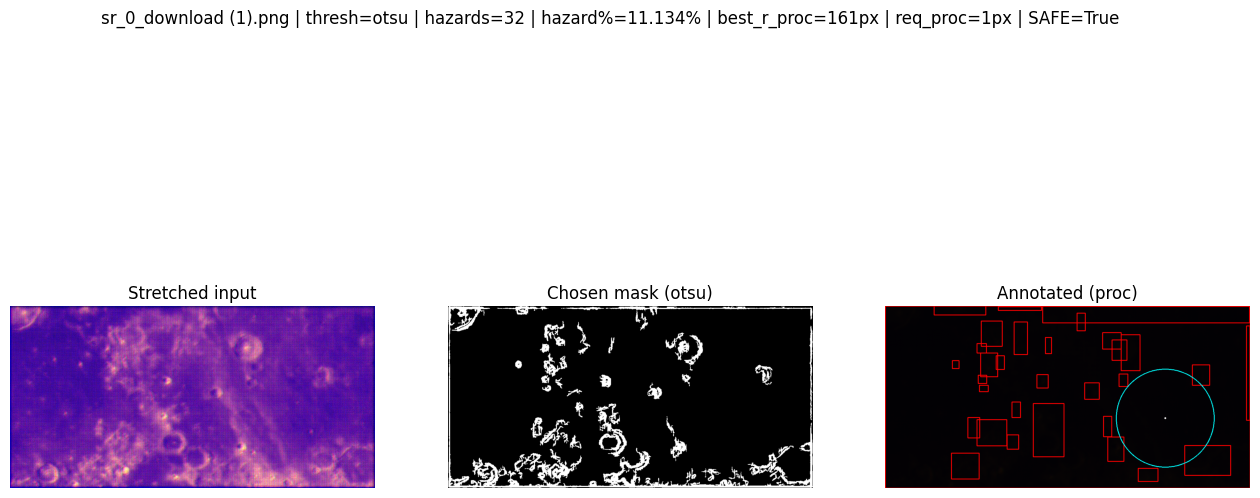

Saved annotated full-res -> Results_EDSR_Annotated_fixed/sr_0_download (1).png

--- sr_1_download (2).png full-res shape=1812x904 dtype= uint8 min/max/mean/std: 0 60 4.6538567042398435 5.820615375318181
sr_1_download (2).png | thresh=otsu | hazards=94 | hazard%=19.599% | best_r_proc=103px | req_proc=1px | SAFE=True


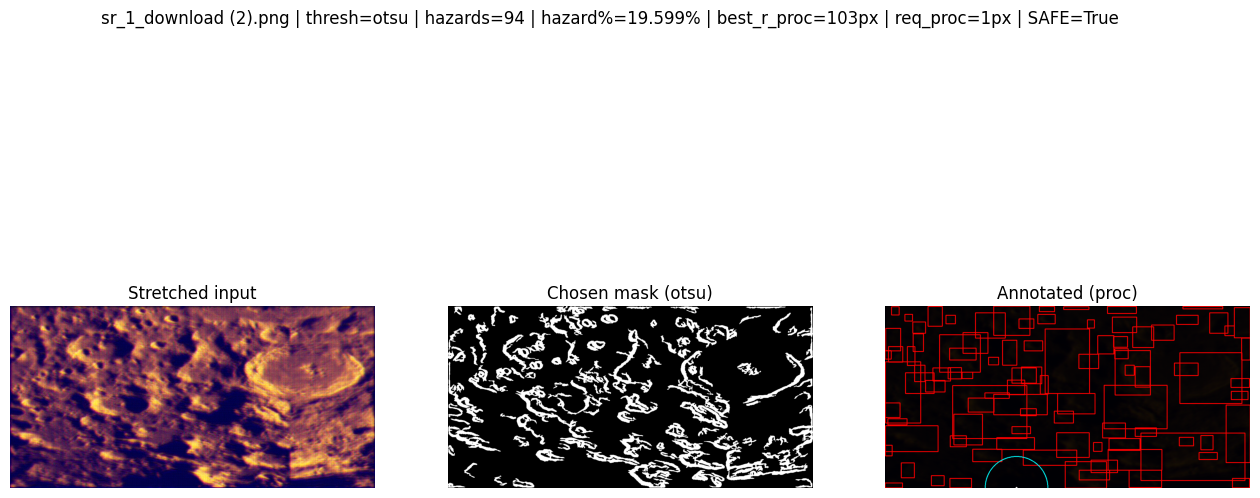

Saved annotated full-res -> Results_EDSR_Annotated_fixed/sr_1_download (2).png

--- sr_2_download (3).png full-res shape=1812x904 dtype= uint8 min/max/mean/std: 0 38 4.499367946889631 4.9791120480738575
sr_2_download (3).png | thresh=otsu | hazards=16 | hazard%=7.708% | best_r_proc=266px | req_proc=1px | SAFE=True


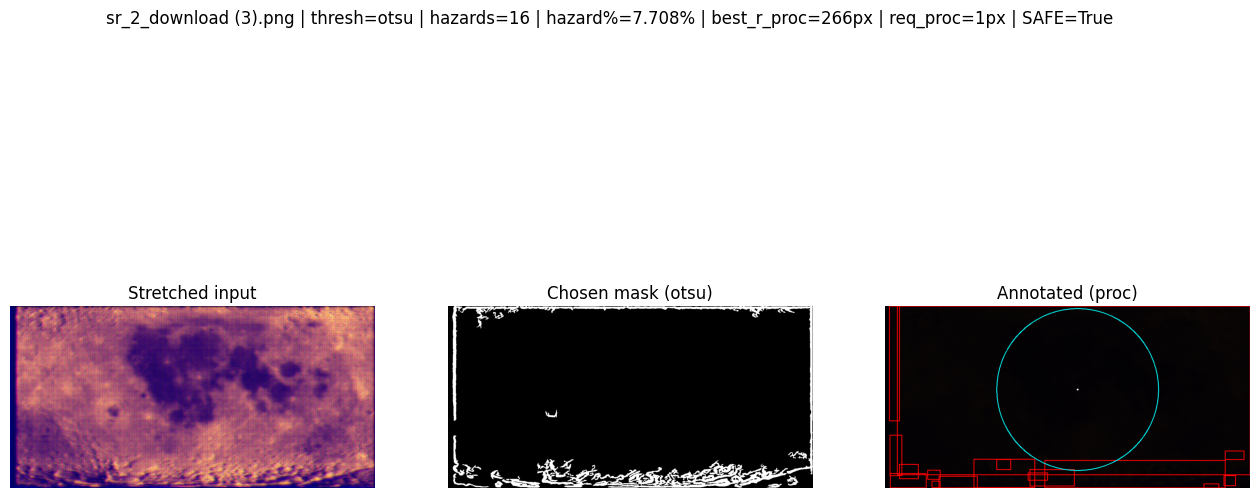

Saved annotated full-res -> Results_EDSR_Annotated_fixed/sr_2_download (3).png

--- sr_3_download.png full-res shape=1812x904 dtype= uint8 min/max/mean/std: 0 47 4.89684490320186 5.26822547519137
sr_3_download.png | thresh=otsu | hazards=47 | hazard%=12.523% | best_r_proc=154px | req_proc=1px | SAFE=True


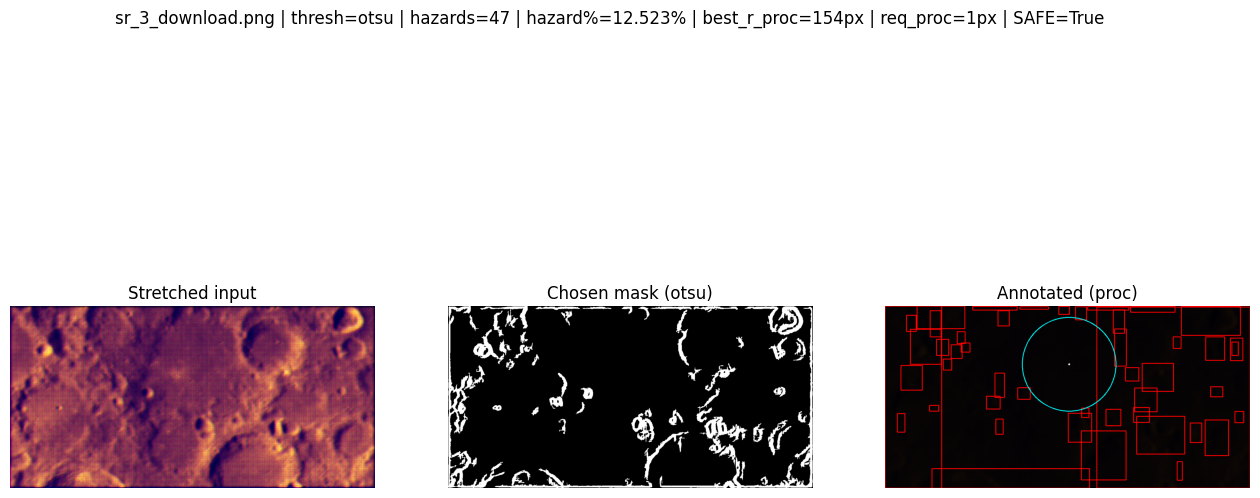

Saved annotated full-res -> Results_EDSR_Annotated_fixed/sr_3_download.png

Done. Outputs saved to: Results_EDSR_Annotated_fixed
CSV summary: Results_EDSR_Annotated_fixed/landing_summary_fixed.csv


In [13]:
# ONE ROBUST CELL: fixes black outputs, shows debug stats, detects hazards, and shows/save annotated images
# Paste & run in Colab. Edit only meters_per_pixel if you know the scale.

import os, io, csv
from PIL import Image, ImageOps
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.morphology import remove_small_objects, closing, opening, disk

# ---------- USER SETTINGS ----------
sr_folder = "Results_EDSR"                 # folder with SR images
out_folder = "Results_EDSR_Annotated_fixed"
os.makedirs(out_folder, exist_ok=True)

# Chandrayaan-3 lander radius w/ 10% margin (meters)
lander_radius_m = 1.1

# Set meters_per_pixel for your SR images (meters / pixel).
# If unknown, try 0.45, 0.2, or 0.05 and inspect results.
meters_per_pixel = 0.45

# processing params
min_hazard_area = 300        # increase to ignore small false positives
max_proc_dim = 1200          # process at this max dimension for speed/display
# ------------------------------------

required_r_px_fullres = max(1, int(round(lander_radius_m / meters_per_pixel)))
print("Using Chandrayaan-3 required radius (px):", required_r_px_fullres, " (meters_per_pixel =", meters_per_pixel, ")")

def imread_pil_as_uint8(path):
    # read with PIL, return RGB uint8 numpy array
    im = Image.open(path)
    im = ImageOps.exif_transpose(im)
    if im.mode == "RGBA":
        im = im.convert("RGB")
    elif im.mode == "L":
        im = im.convert("RGB")
    elif im.mode == "I" or im.mode == "F":
        # convert float/int images to uint8 by scaling
        arr = np.array(im).astype(np.float32)
        # scale to 0-255 using percentiles
        p2, p98 = np.percentile(arr, (1,99))
        arr = np.clip((arr - p2) * 255.0 / (p98 - p2 + 1e-8), 0, 255)
        ims = np.stack([arr,arr,arr], axis=-1).astype(np.uint8)
        return ims
    return np.array(im.convert("RGB")).astype(np.uint8)

def autoscale_uint8(img):
    # input: uint8 RGB
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    p2, p98 = np.percentile(gray, (2,98))
    if p98 - p2 < 8:
        # very low contrast -> stronger stretch + gamma boost
        stretched = np.clip((img.astype(np.float32) - p2) * 255.0 / (max(1.0, p98 - p2)), 0, 255).astype(np.uint8)
        # slight gamma
        gamma = 0.9
        lut = np.array([((i/255.0)**(1.0/gamma))*255 for i in range(256)]).astype('uint8')
        stretched = cv2.LUT(stretched, lut)
    else:
        stretched = np.clip((img.astype(np.float32) - p2) * 255.0 / (p98 - p2 + 1e-8), 0, 255).astype(np.uint8)
    return stretched

def compute_grad_mask(img_gray):
    # strong blur -> Sobel magnitude -> normalized
    blur = cv2.GaussianBlur(img_gray, (9,9), 0)
    gx = cv2.Sobel(blur, cv2.CV_32F, 1, 0, ksize=5)
    gy = cv2.Sobel(blur, cv2.CV_32F, 0, 1, ksize=5)
    mag = cv2.magnitude(gx, gy)
    if mag.max() <= 0:
        norm = np.zeros_like(mag, dtype=np.uint8)
    else:
        norm = np.clip((mag / (mag.max()+1e-8) * 255.0), 0, 255).astype(np.uint8)
    return norm

def auto_threshold_and_clean(norm):
    # try several threshold strategies and pick the one producing hazard% in (0.3, 40)
    h,w = norm.shape
    candidates = []
    # Otsu
    _, th_otsu = cv2.threshold(norm, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    candidates.append(("otsu", th_otsu))
    # percentile thresholds
    for pct in (80,85,90,92,95):
        thr = np.percentile(norm, pct)
        _, th = cv2.threshold(norm, thr, 255, cv2.THRESH_BINARY)
        candidates.append((f"p{pct}", th))
    # pick best
    best = None
    for name, m in candidates:
        # clean small objects
        m_bool = m > 0
        m_clean = remove_small_objects(m_bool, min_size=min_hazard_area)
        mask = (m_clean.astype(np.uint8) * 255)
        perc = 100.0 * (mask>0).sum() / (h*w)
        # accept if between thresholds
        if 0.3 < perc < 40.0:
            best = (name, mask, perc)
            break
    if best is None:
        # fallback: choose candidate with perc closest to 5%
        best = None
        best_diff = 1e9
        for name, m in candidates:
            m_bool = m > 0
            m_clean = remove_small_objects(m_bool, min_size=min_hazard_area)
            mask = (m_clean.astype(np.uint8) * 255)
            perc = 100.0 * (mask>0).sum() / (h*w)
            diff = abs(perc - 5.0)
            if diff < best_diff:
                best_diff = diff
                best = (name, mask, perc)
    return best  # (name, mask_uint8, perc)

def find_landing_and_decide(mask, required_px):
    free = (mask == 0).astype(np.uint8)
    if free.sum() == 0:
        return 0,0,0,False
    dist = cv2.distanceTransform(free, cv2.DIST_L2, 5)
    ys, xs = np.where(dist >= required_px)
    if len(ys) > 0:
        idx = np.argmax(dist[ys, xs])
        cy, cx = int(ys[idx]), int(xs[idx])
        best_r = int(dist[cy, cx])
        return cx, cy, best_r, True
    # fallback to global max
    _, _, _, maxLoc = cv2.minMaxLoc(dist)
    cx, cy = int(maxLoc[0]), int(maxLoc[1])
    best_r = int(dist[cy, cx]) if dist.max() > 0 else 0
    return cx, cy, best_r, False

# ---------- iterate over images ----------
files = sorted([f for f in os.listdir(sr_folder) if f.lower().endswith((".png",".jpg",".jpeg",".tif",".tiff"))])
if len(files) == 0:
    raise SystemExit(f"No images in folder '{sr_folder}'. Place SR images there and re-run.")

csv_path = os.path.join(out_folder, "landing_summary_fixed.csv")
with open(csv_path, "w", newline="") as cf:
    writer = csv.writer(cf)
    writer.writerow(["filename","shape_fullres","dtype","min","max","mean","std","chosen_thresh","hazard_percent","hazard_count","best_cx_full","best_cy_full","best_r_full_px","required_r_full_px","is_safe"])

for fname in files:
    path = os.path.join(sr_folder, fname)
    try:
        img = imread_pil_as_uint8(path)  # RGB uint8
    except Exception as e:
        print("READ ERROR", fname, e)
        continue

    Hf, Wf = img.shape[:2]
    print("\n---", fname, f"full-res shape={Wf}x{Hf}", "dtype=", img.dtype, "min/max/mean/std:",
          int(img.min()), int(img.max()), float(img.mean()), float(img.std()))

    # downscale for processing/display
    scale = 1.0
    if max(Hf, Wf) > max_proc_dim:
        scale = max_proc_dim / float(max(Hf, Wf))
        proc = cv2.resize(img, (int(Wf*scale), int(Hf*scale)), interpolation=cv2.INTER_AREA)
    else:
        proc = img.copy()
    proc_rgb = proc.copy()
    proc_gray = cv2.cvtColor(proc_rgb, cv2.COLOR_RGB2GRAY)

    # autoscale/stretch to avoid black outputs
    stretched = autoscale_uint8(proc_rgb)
    stretched_gray = cv2.cvtColor(stretched, cv2.COLOR_RGB2GRAY)

    # compute gradient magnitude
    grad_u8 = compute_grad_mask(stretched_gray)

    # choose best threshold & clean
    name, mask_proc, hazard_perc = auto_threshold_and_clean(grad_u8)
    # ensure mask is uint8
    mask_proc = mask_proc.astype(np.uint8)

    # find landing in processed coords
    required_px_proc = max(1, int(round(required_r_px_fullres * scale)))
    bx, by, best_r_proc, is_safe_proc = find_landing_and_decide(mask_proc, required_px_proc)

    # count hazards (contours) on processed mask
    contours, _ = cv2.findContours(mask_proc.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    hazard_count = sum(1 for c in contours if cv2.contourArea(c) >= min_hazard_area)

    # annotate processed image for display
    ann_proc = proc_rgb.copy()
    for c in contours:
        if cv2.contourArea(c) < min_hazard_area: continue
        x,y,wc,hc = cv2.boundingRect(c)
        cv2.rectangle(ann_proc, (x,y), (x+wc, y+hc), (255,0,0), 2)   # red boxes

    # circles: maximal fit (cyan), required (green/red)
    cv2.circle(ann_proc, (bx, by), max(1, best_r_proc), (0,255,255), 2)
    req_color = (0,255,0) if is_safe_proc else (255,0,0)
    cv2.circle(ann_proc, (bx, by), required_px_proc, req_color, 3)
    cv2.circle(ann_proc, (bx, by), 3, (255,255,255), -1)

    header = (f"{fname} | thresh={name} | hazards={hazard_count} | hazard%={hazard_perc:.3f}% | "
              f"best_r_proc={best_r_proc}px | req_proc={required_px_proc}px | SAFE={is_safe_proc}")
    print(header)

    # display original (stretched), mask, and annotated
    fig_imgs = [stretched, cv2.cvtColor(mask_proc, cv2.COLOR_GRAY2RGB), ann_proc]
    fig_titles = ["Stretched input", f"Chosen mask ({name})", "Annotated (proc)"]
    plt.figure(figsize=(16,8))
    for i,imgv in enumerate(fig_imgs):
        plt.subplot(1,3,i+1)
        plt.imshow(imgv if imgv.ndim==3 else imgv, cmap='gray' if imgv.ndim==2 else None)
        plt.title(fig_titles[i]); plt.axis('off')
    plt.suptitle(header)
    plt.show()

    # Save annotated full-res: map processed coords back to full-res
    ann_full = img.copy()
    cx_full = int(round(bx / scale))
    cy_full = int(round(by / scale))
    best_r_full = int(round(best_r_proc / scale))
    req_full = required_r_px_fullres
    # draw
    cv2.circle(ann_full, (cx_full, cy_full), max(1, best_r_full), (0,255,255), 4)
    cv2.circle(ann_full, (cx_full, cy_full), req_full, (0,255,0) if is_safe_proc else (255,0,0), 5)
    cv2.circle(ann_full, (cx_full, cy_full), 8, (255,255,255), -1)

    savepath = os.path.join(out_folder, fname)
    # convert RGB->BGR and save
    cv2.imwrite(savepath, cv2.cvtColor(ann_full, cv2.COLOR_RGB2BGR))
    print("Saved annotated full-res ->", savepath)

    # write csv row
    with open(csv_path, "a", newline="") as cf:
        writer = csv.writer(cf)
        writer.writerow([fname, f"{Wf}x{Hf}", str(img.dtype), int(img.min()), int(img.max()),
                         float(img.mean()), float(img.std()), name, f"{hazard_perc:.6f}", hazard_count,
                         cx_full, cy_full, best_r_full, required_r_px_fullres, is_safe_proc])

print("\nDone. Outputs saved to:", out_folder)
print("CSV summary:", csv_path)
